### Table of Contents

* [I. Creating The Embbeding](#chapter1)
    * [1. Preprocessing](#section_1_1)
    * [2. Training The Embbeding Model](#section_1_2)
* [II. Transforming Text into Vectors](#chapter2)
    * [1. Training Data](#section_2_1)
    * [2. Validation Data](#section_2_2)
    * [3. Test Data](#section_2_3)
* [III. Machine Learning Classification Models](#chapter3)
    * [1. Naive Bayes](#section_3_1)
    * [2. Logistic Regression](#section_3_2)
    * [3. Random Forest](#section_3_3)
    * [4. SVM](#section_3_4)
* [IV. Results](#chapter4)
* [V. Making the predictions for Submission](#chapter5)

In [22]:
import pandas as pd
import numpy as np
from evaluate import model_Evaluate
import time

### I. Creating The Embbeding <a class="anchor" id="chapter1"></a>

#### 1. Preprocessing <a class="anchor" id="section_1_1"></a>

In fact, we import the already preprocessed data, that have been creating using the preprocess_data function we provide in the "utils" directory. The data has been saved in csv format and can be found on the Google Drive repo.

In [2]:
data = pd.read_csv('data_preprocessed.csv')
data_test = pd.read_csv('data_submission_preprocessed.csv')

Then, we tokenize :

In [3]:
from gensim.utils import simple_preprocess
data['tweet_tokenized'] = [simple_preprocess(line, deacc=True) for line in data['tweet']]
data_test['tweet_tokenized'] = [simple_preprocess(line, deacc=True) for line in data_test['tweet']]

And we use stemming, because preprocessed data don't include a stemming step, and it shows a better performance.

In [4]:
from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()
# Get the stemmed_tokens
data['tweet_stemmed'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in data['tweet_tokenized']]
data_test['tweet_stemmed'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in data_test['tweet_tokenized']]

We put together all the preprocessed tokens together in order to train our embedding on all the words that might occur both in the train and the test data.

In [ ]:
stemmed_tokens = pd.concat([data['tweet_stemmed'],data_test['tweet_stemmed']], axis=0)

#### 2. Training the embedding model <a class="anchor" id="section_1_2"></a>

In [ ]:
from gensim.models import Word2Vec
import time

size = 500 # size of the vector
window = 5 # size of the window
min_count = 1 # min occurence for taking the number in the vocabulary
workers = 8 # number of CPUs used
sg = 1 # we use Skip-Gram

start_time = time.time()
# Train the Word2Vec Model
model = Word2Vec(stemmed_tokens, min_count = min_count, vector_size = size, workers = workers, window = window, sg = sg)
print("Time taken to train word2vec model: " + str(time.time() - start_time))

In [ ]:
# If we want to save the model : 
#model.save('w2v_500.model')

In [5]:
# If we already have trained the model, we import it
from gensim.models import Word2Vec
model = Word2Vec.load('w2v_500.model') 

### II. Transforming Text into Vectors <a class="anchor" id="chapter2"></a>

In [6]:
# We clean data from potentially empty tweets after the processing
indexes_to_drop = data[data["tweet_stemmed"].str.len() == 0].index.values
data.drop(indexes_to_drop, axis=0, inplace=True)

We first split the labeled data, by keeping 80% for training and 20% for validation.

In [7]:
from sklearn.model_selection import train_test_split
data_train, data_valid = train_test_split(data, test_size=0.2, random_state=26105111)

#### 1. Training Data <a class="anchor" id="section_2_1"></a>

In [8]:
X_train_temp = []
for index, row in data_train.iterrows():
        # We represent each tweet as the mean of its words vector
        vector = np.array((np.mean([model.wv[token]  for token in row['tweet_stemmed']], axis=0)))
        X_train_temp.append(vector)

In [9]:
X_train_array = np.array(X_train_temp)
y_train_array = data_train['positive'].values

#### 2. Validation Data <a class="anchor" id="section_2_2"></a>

In [10]:
X_valid_temp = []
for index, row in data_valid.iterrows():
        # We represent each tweet as the mean of its words vector
        vector = np.array((np.mean([model.wv[token]  for token in row['tweet_stemmed']], axis=0)))
        X_valid_temp.append(vector)

In [11]:
X_valid_array = np.array(X_valid_temp)
y_valid_array = data_valid['positive'].values

#### 3. Test Data <a class="anchor" id="section_2_3"></a>

In [32]:
X_test_temp = []
for index, row in data_test.iterrows():
        vector = np.array((np.mean([model.wv[token]  for token in row['tweet_stemmed']], axis=0)))
        X_test_temp.append(vector)

In [33]:
X_test_array = np.array(X_test_temp)

### III. Machine Learning Classification Models <a class="anchor" id="chapter3"></a>

#### 1. Naive Bayes <a class="anchor" id="section_3_1"></a>

In [19]:
from sklearn.naive_bayes import BernoulliNB

clf_nb = BernoulliNB(alpha=0.1)
start_time = time.time()
clf_nb.fit(X_train_array, y_train_array)
print("Time taken to train the model: {:.2f}".format(time.time() - start_time))

Time taken to train the model: 36.23


In [20]:
score_nb = clf_nb.score(X_valid_array, y_valid_array)

In [21]:
print('Accuracy on the validation set : {:.5f}'.format(score_nb))

Accuracy on the validation set : 0.61554


#### 2. Logistic Regression <a class="anchor" id="section_3_2"></a>

In [23]:
from sklearn.linear_model import LogisticRegression

clf_lg = LogisticRegression(solver='lbfgs', C=0.1, max_iter=400)
start_time = time.time()
clf_lg.fit(X_train_array, y_train_array)
print("Time taken to train the model: {:.2f}".format(time.time() - start_time))

Time taken to train the model: 163.70


In [24]:
score_lg = clf_lg.score(X_valid_array, y_valid_array)

In [25]:
print('Accuracy on the validation set : {:.5f}'.format(score_lg))

Accuracy on the validation set : 0.78094


#### 3. Random Forest<a class="anchor" id="section_3_3"></a>

In [26]:
from sklearn.ensemble import RandomForestClassifier

clf_rdf = RandomForestClassifier(max_depth=3, bootstrap=True, n_jobs=-1, min_samples_leaf=5)
start_time = time.time()
clf_rdf.fit(X_train_array, y_train_array)
print("Time taken to train the model: {:.2f}".format(time.time() - start_time))

Time taken to train the model: 178.35


In [27]:
score_rdf = clf_rdf.score(X_valid_array, y_valid_array)

In [28]:
print('Accuracy on the validation set : {:.5f}'.format(score_rdf))

Accuracy on the validation set : 0.63925


#### 4. SVM<a class="anchor" id="section_3_4"></a>

In [14]:
# For the SVM classifier, we use only the 100 000 first tweets for the training because of time expensiveness
# of the SVM training process in the number of data points used to create the margins. Although, it gives quite 
# good results

from sklearn import svm
clf_svm = svm.LinearSVC(C=0.1, max_iter=3000)
start_time = time.time()
clf_svm.fit(X_train_array[:100000], y_train_array[:100000])
print("Time taken to train the model: {:.2f}".format(time.time() - start_time))

Time taken to train the model: 8.67


In [15]:
score_svm = clf_svm.score(X_valid_array, y_valid_array)

In [36]:
print('Accuracy on the validation set : {:.5f}'.format(score_svm))

Accuracy on the validation set : 0.77991


### IV. Results <a class="anchor" id="chapter4"></a>

Finally, we show the main classification metrics for each of our classsifier :

Naive Bayes :

              precision    recall  f1-score   support

          -1       0.68      0.45      0.54    248086
           1       0.58      0.78      0.67    243544

    accuracy                           0.62    491630
   macro avg       0.63      0.62      0.61    491630
weighted avg       0.63      0.62      0.60    491630



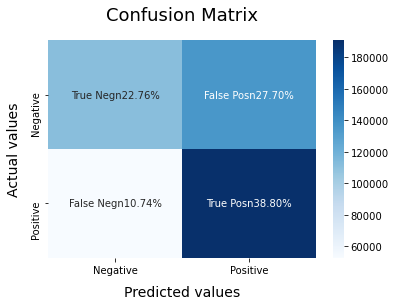

In [29]:
print("Naive Bayes :\n")
model_Evaluate(clf_nb, X_valid_array, y_valid_array)

Logistic Regression :

              precision    recall  f1-score   support

          -1       0.80      0.76      0.78    248086
           1       0.77      0.80      0.78    243544

    accuracy                           0.78    491630
   macro avg       0.78      0.78      0.78    491630
weighted avg       0.78      0.78      0.78    491630



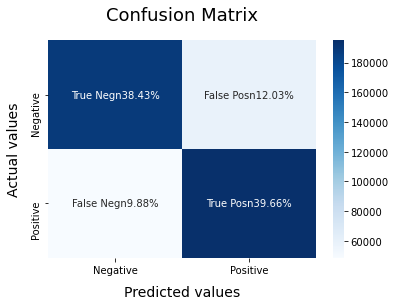

In [30]:
print("Logistic Regression :\n")
model_Evaluate(clf_lg, X_valid_array, y_valid_array)

Random Forest :

              precision    recall  f1-score   support

          -1       0.78      0.40      0.53    248086
           1       0.59      0.89      0.71    243544

    accuracy                           0.64    491630
   macro avg       0.69      0.64      0.62    491630
weighted avg       0.69      0.64      0.62    491630



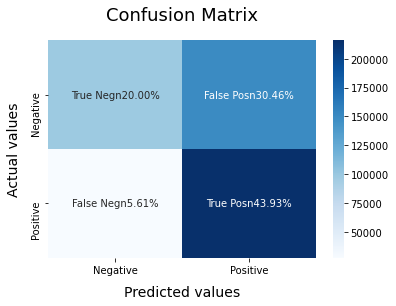

In [31]:
print("Random Forest :\n")
model_Evaluate(clf_rdf, X_valid_array, y_valid_array)

SVM :

              precision    recall  f1-score   support

          -1       0.80      0.76      0.78    248086
           1       0.76      0.80      0.78    243544

    accuracy                           0.78    491630
   macro avg       0.78      0.78      0.78    491630
weighted avg       0.78      0.78      0.78    491630



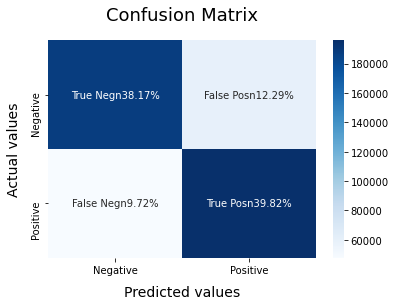

In [18]:
print("SVM :\n")
model_Evaluate(clf_svm, X_valid_array, y_valid_array)

To conclude, the best accuracy was found with the Logistic Regression classifier, that we use to submit a prediction on AI Crowd down bellow :

### V. Making the predictions for Submission <a class="anchor" id="chapter5"></a>

In [35]:
y_test_pred = clf_lg.predict(X_test_array)
#We rename the Id column in order to be accepted in the submission platform
data_test = data_test.rename(columns={'tweet_idx':'Id'})
# We add the prections column
data_test['Prediction'] = y_test_pred
# We save to a csv file only Id, Prediction columns
data_test[['Id', 'Prediction']].to_csv('submission.csv', encoding='utf-8', index=False)